In [1]:
from astroquery.vizier import Vizier as Vizier
from astroquery.skyview import SkyView
import astropy.units as u
import astropy.coordinates as coord
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")
from astropy.coordinates import SkyCoord
import io
import requests
from astropy.table import Table
from PIL import Image
import requests
from io import BytesIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from matplotlib.patches import Circle
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Data Preprocessing

Load Data

In [2]:
clust_verified = pd.read_csv('verified candidates.csv')

In [3]:
clust_verified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Glon               740 non-null    float64
 1   Glat               740 non-null    float64
 2   comments           120 non-null    object 
 3   3_6mag             740 non-null    float64
 4   e_3_6mag           740 non-null    float64
 5   4_5mag             740 non-null    float64
 6   e_4_5mag           740 non-null    float64
 7   size               740 non-null    float64
 8   sources_cluster    740 non-null    int64  
 9   tile               740 non-null    object 
 10  color_bin          740 non-null    object 
 11  sources_20_arcmin  740 non-null    int64  
 12  sources_tile       740 non-null    int64  
 13  significance       740 non-null    float64
 14  overdensity        740 non-null    float64
dtypes: float64(9), int64(3), object(3)
memory usage: 86.8+ KB


Checking the columns of the data

In [4]:
clust_verified.columns

Index(['Glon', 'Glat', 'comments', '3_6mag', 'e_3_6mag', '4_5mag', 'e_4_5mag',
       'size', 'sources_cluster', 'tile', 'color_bin', 'sources_20_arcmin',
       'sources_tile', 'significance', 'overdensity'],
      dtype='object')

In [5]:
clust_verified.head()

,Glon,Glat,comments,3_6mag,e_3_6mag,4_5mag,e_4_5mag,size,sources_cluster,tile,color_bin,sources_20_arcmin,sources_tile,significance,overdensity
0,330.0379,1.0447,G3CC_32,13.222647,0.089588,11.842412,0.107118,0.006057,17,split_295.0_335.0/35_4.csv,0.6-4.0,339,209364,3.460917,7.16
1,15.0326,0.8518,NaN,13.869500,0.126571,12.553929,0.133786,0.045419,14,split_15.0_35.0/0_4.csv,0.6-4.0,49,66741,0.673157,2.18
2,350.1153,0.0960,G3CC_44,13.287500,0.115714,11.979643,0.112786,0.011990,14,split_350.0_360.0/0_4.csv,0.6-4.0,443,373558,1.077837,7.35
3,34.4604,0.2480,NaN,13.879467,0.129267,12.598800,0.139333,0.012455,15,split_15.0_35.0/19_3.csv,0.6-4.0,592,208736,1.487271,3.32
4,12.8968,0.4890,NaN,12.929737,0.111105,11.650474,0.139211,0.014854,19,split_0.0_15.0/12_5.csv,0.6-4.0,316,157738,1.817078,4.00


Check for NaN and $\infinity$ values

In [6]:
for c in clust_verified.columns:
    print('NaN values in column ',c,'=',clust_verified[c].isna().sum())
    
for c in clust_verified.columns:
    print('Infinity values in column ',c, ': ', len(np.where(clust_verified[c]==np.inf)[0]))

NaN values in column  Glon = 0
NaN values in column  Glat = 0
NaN values in column  comments = 620
NaN values in column  3_6mag = 0
NaN values in column  e_3_6mag = 0
NaN values in column  4_5mag = 0
NaN values in column  e_4_5mag = 0
NaN values in column  size = 0
NaN values in column  sources_cluster = 0
NaN values in column  tile = 0
NaN values in column  color_bin = 0
NaN values in column  sources_20_arcmin = 0
NaN values in column  sources_tile = 0
NaN values in column  significance = 0
NaN values in column  overdensity = 0
Infinity values in column  Glon :  0
Infinity values in column  Glat :  0
Infinity values in column  comments :  0
Infinity values in column  3_6mag :  0
Infinity values in column  e_3_6mag :  0
Infinity values in column  4_5mag :  0
Infinity values in column  e_4_5mag :  0
Infinity values in column  size :  0
Infinity values in column  sources_cluster :  0
Infinity values in column  tile :  0
Infinity values in column  color_bin :  0
Infinity values in column 

1. The column 'comments' is structured in such a way that NaN values are candidates which are not assigned any clusters and known clusters have a string value with name of the cluster. 

2. To work with ML algorithms we need numerical values, so logically we'll assign a numeral value of '1' to known clusters and '0' to unknown candidates (candidates having NaN values).

3. There is one infinity value in *overdensity*, we'll replace it with a large number, 99

In [7]:
clust_verified['comments'].fillna(0, inplace=True)
for i in range(clust_verified.shape[0]):
    if clust_verified['comments'][i] != 0:
        clust_verified['comments'][i] = 1
        
clust_verified['overdensity'][clust_verified['overdensity']==np.inf] = 99

Check NaN and $\infinity$ values again

In [8]:
for c in clust_verified.columns:
    print('NaN values in column ',c,'=',clust_verified[c].isna().sum())
    
for c in clust_verified.columns:
    print('Infinity values in column ',c, ': ', len(np.where(clust_verified[c]==np.inf)[0]))

NaN values in column  Glon = 0
NaN values in column  Glat = 0
NaN values in column  comments = 0
NaN values in column  3_6mag = 0
NaN values in column  e_3_6mag = 0
NaN values in column  4_5mag = 0
NaN values in column  e_4_5mag = 0
NaN values in column  size = 0
NaN values in column  sources_cluster = 0
NaN values in column  tile = 0
NaN values in column  color_bin = 0
NaN values in column  sources_20_arcmin = 0
NaN values in column  sources_tile = 0
NaN values in column  significance = 0
NaN values in column  overdensity = 0
Infinity values in column  Glon :  0
Infinity values in column  Glat :  0
Infinity values in column  comments :  0
Infinity values in column  3_6mag :  0
Infinity values in column  e_3_6mag :  0
Infinity values in column  4_5mag :  0
Infinity values in column  e_4_5mag :  0
Infinity values in column  size :  0
Infinity values in column  sources_cluster :  0
Infinity values in column  tile :  0
Infinity values in column  color_bin :  0
Infinity values in column  s

But the conversion has led to the data type of 'comments' column as *object* which must be converted to integer (*int*)

In [9]:
clust_verified['comments'] = clust_verified['comments'].astype(str).astype(int)
clust_verified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Glon               740 non-null    float64
 1   Glat               740 non-null    float64
 2   comments           740 non-null    int32  
 3   3_6mag             740 non-null    float64
 4   e_3_6mag           740 non-null    float64
 5   4_5mag             740 non-null    float64
 6   e_4_5mag           740 non-null    float64
 7   size               740 non-null    float64
 8   sources_cluster    740 non-null    int64  
 9   tile               740 non-null    object 
 10  color_bin          740 non-null    object 
 11  sources_20_arcmin  740 non-null    int64  
 12  sources_tile       740 non-null    int64  
 13  significance       740 non-null    float64
 14  overdensity        740 non-null    float64
dtypes: float64(9), int32(1), int64(3), object(2)
memory usage: 84.0+ KB


We should select the columns which are relevant with our analysis. For e.g. the galactic coordinates of a cluster is not very relevant to our analysis, so we could drop it. The 'color_bin' is same for all the sources, so it can be dropped to reduce the unnecesary complexities. The 'tile' column just says what tile was used for a particular cluster so it's not relevant either.

In [55]:
attr = ['3_6mag', 'e_3_6mag', '4_5mag', 'e_4_5mag', 'size',
       'sources_cluster', 'sources_20_arcmin',
       'sources_tile', 'significance', 'overdensity', 'comments', 'color']

In [11]:
clusters = clust_verified[attr]

Splitting the data

In [12]:
#For reproducibility
np.random.seed(10)

In [227]:
train_set, test_set = train_test_split(clusters, test_size=0.3, random_state=10)
X_train = train_set.drop('comments', axis=1)
y_train = train_set['comments']
X_test = test_set.drop('comments', axis=1)
y_test = test_set['comments']

In [41]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train_index, test_index in split.split(clusters, clusters["comments"]):
    strat_train_set = clusters.loc[train_index]
    strat_test_set = clusters.loc[test_index]
X_train_strat = strat_train_set.drop('comments', axis=1)
y_train_strat = strat_train_set['comments']
X_test_strat = strat_test_set.drop('comments', axis=1)
y_test_strat = strat_test_set['comments']

We will only work on the training data set now
Gaining insights in the training data

In [30]:
clusters['color'] = clusters['3_6mag']-clusters['4_5mag']

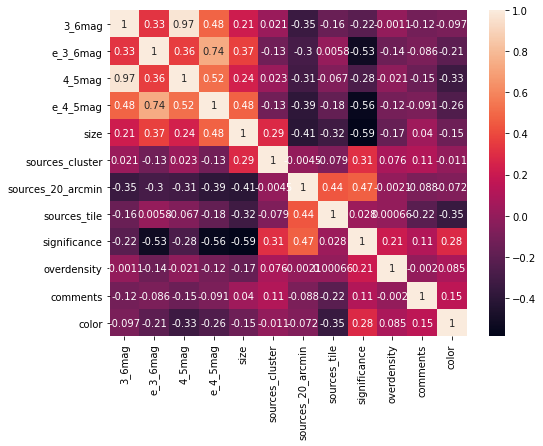

In [32]:
corr = clusters.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.show()

In [33]:
corr['comments'].sort_values(ascending=False)

comments             1.000000
color                0.151928
sources_cluster      0.111505
significance         0.106766
size                 0.039865
overdensity         -0.002040
e_3_6mag            -0.085941
sources_20_arcmin   -0.088102
e_4_5mag            -0.091063
3_6mag              -0.120361
4_5mag              -0.150275
sources_tile        -0.220748
Name: comments, dtype: float64

In [36]:
top_attr = ['comments','sources_cluster', 'significance', '3_6mag', '4_5mag', 'sources_tile', 'color']

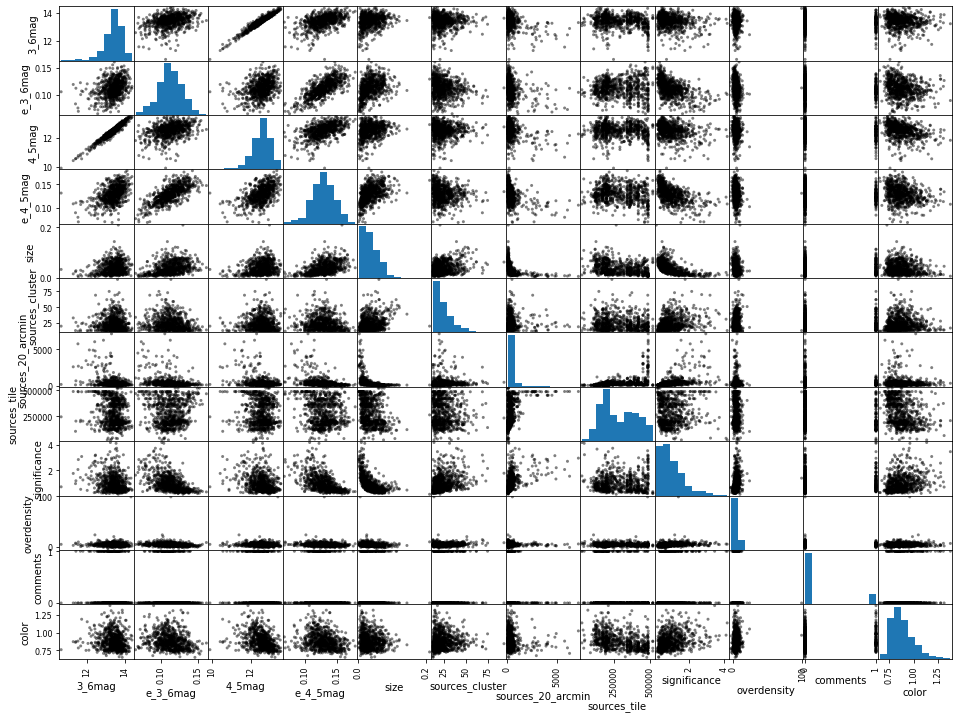

In [57]:
scatter_matrix(clusters[attr], figsize=(16,12), c='black')
plt.show()

In [38]:
clusters.describe()

,3_6mag,e_3_6mag,4_5mag,e_4_5mag,size,sources_cluster,sources_20_arcmin,sources_tile,significance,overdensity,comments,color
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,13.387854,0.112224,12.505932,0.128869,0.038219,24.414865,461.124324,282839.270270,0.988071,4.844203,0.162162,0.881922
std,0.466143,0.016030,0.491472,0.017938,0.024058,11.160633,787.341393,119701.848518,0.668698,4.466915,0.368849,0.116836
min,10.657600,0.065176,9.900250,0.068000,0.003424,12.000000,27.000000,25374.000000,0.104792,-3.110000,0.000000,0.649083
25%,13.195148,0.102185,12.256652,0.116661,0.019303,16.000000,121.000000,187166.000000,0.488039,2.937500,0.000000,0.795630
50%,13.435527,0.112209,12.561430,0.129110,0.033294,22.000000,233.000000,257243.000000,0.819078,4.390000,0.000000,0.861548
75%,13.685706,0.123094,12.841369,0.140741,0.053180,30.000000,440.750000,389718.000000,1.305250,6.052500,0.000000,0.944042
max,14.380824,0.160786,13.515625,0.179077,0.209417,94.000000,7104.000000,519810.000000,4.183077,99.000000,1.000000,1.380235


In [75]:
X_top_attr = ['sources_cluster', 'significance', '4_5mag', 'color', 'sources_tile']
X_attr = ['3_6mag',
 'e_3_6mag',
 '4_5mag',
 'e_4_5mag',
 'size',
 'sources_cluster',
 'sources_20_arcmin',
 'sources_tile',
 'significance',
 'overdensity',
 'color']
X_train_scaled = StandardScaler().fit_transform(X_train[X_top_attr])

In [76]:
rf = RandomForestClassifier(random_state=10, n_estimators=200)

In [177]:
rf.fit(np.array(X_train_scaled), np.array(y_train))

RandomForestClassifier(n_estimators=200, random_state=10)

<BarContainer object of 5 artists>

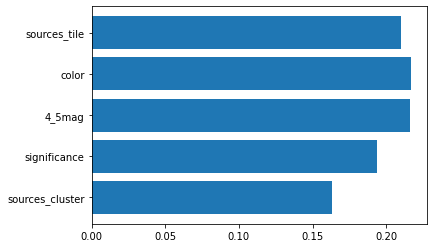

In [178]:
rf.feature_importances_
plt.barh(X_top_attr, rf.feature_importances_)

In [179]:
X_test_scaled = StandardScaler().fit_transform(X_test[X_top_attr])
y_pred = rf.predict(np.array(X_test_scaled))

In [180]:
rf.score(X_test_scaled, y_test)

0.8423423423423423

In [181]:
metrics.accuracy_score(y_test, y_pred)

0.8423423423423423

In [83]:
rf1.score(X)

NameError: name 'rf1' is not defined

In [182]:
np.where(y_pred==1)

(array([ 35,  58,  87, 111, 135, 167, 205, 214], dtype=int64),)

In [183]:
np.where(y_test==1)

(array([  2,  14,  18,  21,  34,  35,  37,  44,  50,  53,  56,  57,  58,
         64,  73,  75,  76,  83,  88,  92, 109, 112, 126, 135, 146, 150,
        152, 158, 163, 167, 170, 174, 177, 180, 183, 201, 214], dtype=int64),)

In [184]:
from sklearn.metrics import confusion_matrix

Text(33.0, 0.5, 'True')

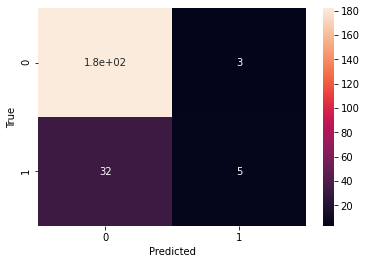

In [185]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

# New

In [224]:
#We cannot directly feed a Pandas data frame to scikit-learn.
#Therefore we need to define a class that transforms our data frame into a numpy array.
#Define class to select a pandas data frame for sklearn input
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [225]:
#Pipeline for standard scaling
scaler_pipeline = Pipeline([
    ('selector',   DataFrameSelector(X_top_attr)),
    ('imputer',    SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ])

In [228]:
train_array = scaler_pipeline.fit_transform(X_train[X_top_attr])
test_array = scaler_pipeline.fit_transform(X_test)

In [229]:
rf1 = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 100, max_features = 4,
                                  random_state = 10)

In [230]:
rf1.fit(train_array, y_train)

RandomForestClassifier(max_features=4, min_samples_leaf=100, random_state=10)

In [231]:
from sklearn.metrics import mean_squared_error


In [233]:
y_pred = rf1.predict(test_array)
rf1_test_mse = mean_squared_error(y_test, y_pred)
rf1_test_rmse = np.sqrt(rf1_test_mse)
rf1_acc = rf1.score(test_array, y_test)
print('The rmse for this model is', rf1_test_rmse, 'translating to an accuracy of', rf1_acc)

The rmse for this model is 0.408248290463863 translating to an accuracy of 0.8333333333333334


In [234]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [235]:
np.array(y_test)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0])

# USE DEEPL

In [89]:
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [91]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train_index, test_index in split.split(clusters, clusters["comments"]):
    strat_train_set = clusters.loc[train_index]
    strat_test_set = clusters.loc[test_index]
X_train_strat = strat_train_set.drop('comments', axis=1)
y_train_strat = strat_train_set['comments']
X_test_strat = strat_test_set.drop('comments', axis=1)
y_test_strat = strat_test_set['comments']

In [93]:
encoder=LabelEncoder()
encoder.fit(y_train_strat)
enc_y_train = encoder.transform(y_train_strat)
encoder.fit(y_test_strat)
enc_y_test = encoder.transform(y_test_strat)

In [143]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(32, input_dim=5, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [144]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [159]:
model.fit(np.array(X_train_strat[X_top_attr]), enc_y_train, 
          epochs=50, batch_size=32, verbose=2,
         validation_split = 0.1, 
          callbacks=[keras.callbacks.EarlyStopping(patience=5, verbose=1),
                        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=2, verbose=1)])

Epoch 1/50
17/17 - 0s - loss: 2.1347 - accuracy: 0.7293 - val_loss: 1.2383 - val_accuracy: 0.9000 - lr: 1.3501e-05 - 302ms/epoch - 18ms/step
Epoch 2/50
17/17 - 0s - loss: 2.3388 - accuracy: 0.7387 - val_loss: 1.2802 - val_accuracy: 0.9000 - lr: 1.3501e-05 - 38ms/epoch - 2ms/step
Epoch 3/50

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.04583727788122e-06.
17/17 - 0s - loss: 1.9410 - accuracy: 0.7575 - val_loss: 1.3297 - val_accuracy: 0.9000 - lr: 1.3501e-05 - 39ms/epoch - 2ms/step
Epoch 4/50
17/17 - 0s - loss: 1.4461 - accuracy: 0.7669 - val_loss: 1.6842 - val_accuracy: 0.1000 - lr: 9.0458e-06 - 38ms/epoch - 2ms/step
Epoch 5/50
17/17 - 0s - loss: 2.0961 - accuracy: 0.7575 - val_loss: 0.3832 - val_accuracy: 0.9000 - lr: 9.0458e-06 - 38ms/epoch - 2ms/step
Epoch 6/50
17/17 - 0s - loss: 0.7797 - accuracy: 0.7312 - val_loss: 0.7781 - val_accuracy: 0.5500 - lr: 9.0458e-06 - 38ms/epoch - 2ms/step
Epoch 7/50

Epoch 00007: ReduceLROnPlateau reducing learning rate to 6.0607108116528

In [160]:
test_loss, test_acc = model.evaluate(np.array(X_test_strat[X_top_attr]), enc_y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.8108


In [168]:
y_pred = model.predict(np.array(X_test_strat[X_top_attr]))

In [171]:
len(y_pred[y_pred>0.5])

22

In [173]:
len(enc_y_test[enc_y_test==1])

24

In [174]:
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = int(1)
    else:
        y_pred[i] = int(0)

In [175]:
np.where(y_pred==1)

(array([  0,   9,  10,  15,  23,  27,  34,  52,  61,  63,  82,  84,  85,
         88,  89,  90, 114, 118, 119, 129, 133, 139], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64))

Text(33.0, 0.5, 'True')

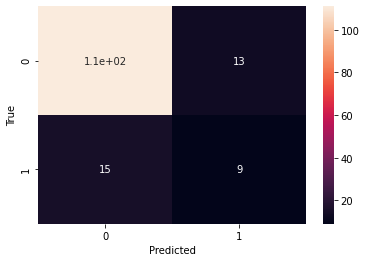

In [176]:
cm = confusion_matrix(enc_y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [152]:
enc_y_test==1

array([False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False,  True, False,  True,  True,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

# New Approach

In [187]:
X = clusters.drop('comments', axis=1)
y = clusters['comments']

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [211]:
X_train = StandardScaler().fit_transform(X_train[X_top_attr])
X_test = StandardScaler().fit_transform(X_test[X_top_attr])

In [212]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit()
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [214]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.797297,0.066667,0.500000
Support Vector Machines,0.797297,0.000000,0.000000
Decision Trees,0.689189,0.400000,0.300000
Random Forest,0.837838,0.266667,0.800000
Naive Bayes,0.810811,0.266667,0.571429
K-Nearest Neighbor,0.837838,0.266667,0.800000


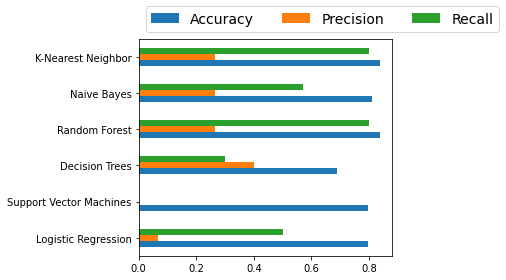

In [215]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.tight_layout()

In [220]:
y_pred = models['K-Nearest Neighbor'].predict(X_test)

In [221]:
np.array(y_test)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1])

In [222]:
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  4
False Positive(FP) =  1
True Negative(TN)  =  58
False Negative(FN) =  11


Text(33.0, 0.5, 'True')

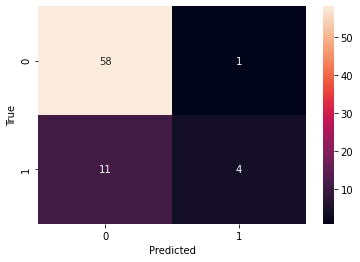

In [223]:
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')